In [2]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
pd.set_option('display.max_rows', None)  # To display all rows 
pd.set_option('display.max_columns', None)  # To display all columns

In [4]:
# Paths to datasets
train_dir = './Training_Set/Training'
val_dir = './Evaluation_Set/Validation'
test_dir = './Test_Set/Test'

train_labels_path = './Training_Set/RFMiD_Training_Labels.csv'
val_labels_path = './Evaluation_Set/RFMiD_Validation_Labels.csv'
test_labels_path = './Test_Set/RFMiD_Testing_Labels.csv'

# Load labels
train_labels = pd.read_csv(train_labels_path)
val_labels = pd.read_csv(val_labels_path)
test_labels = pd.read_csv(test_labels_path)

# Print dataset shapes
print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

Train labels shape: (1920, 47)
Validation labels shape: (640, 47)
Test labels shape: (640, 47)


In [5]:
# Data Preprocessing
def load_images_and_labels(image_dir, labels_df):
    images = []
    labels = []
    for index, row in labels_df.iterrows():
        img_path = os.path.join(image_dir, f"{row['ID']}.png")
        if os.path.exists(img_path):
            img = cv2.imread(img_path)  # Load the image in BGR format
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = cv2.resize(img, (224, 224))  # Resize images to 224x224
            images.append(img)
            labels.append(row['Disease_Risk'])
    return np.array(images), np.array(labels)

# Load images and labels
X_train, y_train = load_images_and_labels(train_dir, train_labels)
X_val, y_val = load_images_and_labels(val_dir, val_labels)
X_test, y_test = load_images_and_labels(test_dir, test_labels)

# Normalize the images
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [6]:
# Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [31]:
# U-Net Model
def build_unet(input_shape=(224, 224, 3)):
    inputs = Input(input_shape)
    
    # Encoder
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(32, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(64, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(256, (3, 3), activation='relu', padding='same')(c4)

    # Decoder (Optional: Eğer segmentasyon yapılacaksa kullanılır)
    u3 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c4)
    u3 = concatenate([u3, c3])
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(u3)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same')(c5)
    
    # Classifier Layer
    f = Flatten()(c4)
    d = Dense(512, activation='relu')(f)
    d = Dropout(0.5)(d)
    outputs = Dense(1, activation='sigmoid')(d)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# U-Net model oluşturma
unet_model = build_unet(input_shape=(224, 224, 3))
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Modeli eğitme
history = unet_model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=20
)

# Model değerlendirme
y_pred = (unet_model.predict(X_test) > 0.2).astype("int32")

c:\Users\MONSTER\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



Epoch 1/20


c:\Users\MONSTER\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning:

The structure of `inputs` doesn't match the expected structure: ['keras_tensor_16']. Received: the structure of inputs=*



60/60 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.7438 - loss: 0.6146 - val_accuracy: 0.7906 - val_loss: 0.5147
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 167s 3s/step - accuracy: 0.7886 - loss: 0.5239 - val_accuracy: 0.7906 - val_loss: 0.5180
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 164s 3s/step - accuracy: 0.7946 - loss: 0.5164 - val_accuracy: 0.7906 - val_loss: 0.5139
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.7792 - loss: 0.5336 - val_accuracy: 0.7906 - val_loss: 0.5197
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.7888 - loss: 0.5268 - val_accuracy: 0.7906 - val_loss: 0.5243
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.8004 - loss: 0.5110 - val_accuracy: 0.7906 - val_loss: 0.5242
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.7980 - loss: 0.5052 - val_accuracy: 0.7906 - val_loss: 0.5144
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 163s 3s/step - accuracy: 0.7997 - loss: 0.5150 - val_accuracy: 0.7906 - val_loss: 0.

In [32]:
# Sonuçları yazdırma
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.790625
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       134
           1       0.79      1.00      0.88       506

    accuracy                           0.79       640
   macro avg       0.40      0.50      0.44       640
weighted avg       0.63      0.79      0.70       640



c:\Users\MONSTER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\MONSTER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\MONSTER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [33]:
# Eğitim geçmişini görselleştirme
fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 41)), y=history.history['accuracy'], mode='lines', name='Train Accuracy'))
fig.add_trace(go.Scatter(x=list(range(1, 41)), y=history.history['val_accuracy'], mode='lines', name='Validation Accuracy'))
fig.update_layout(title='Model Accuracy', xaxis_title='Epoch', yaxis_title='Accuracy')
fig.show()

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(1, 41)), y=history.history['loss'], mode='lines', name='Train Loss'))
fig.add_trace(go.Scatter(x=list(range(1, 41)), y=history.history['val_loss'], mode='lines', name='Validation Loss'))
fig.update_layout(title='Model Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()


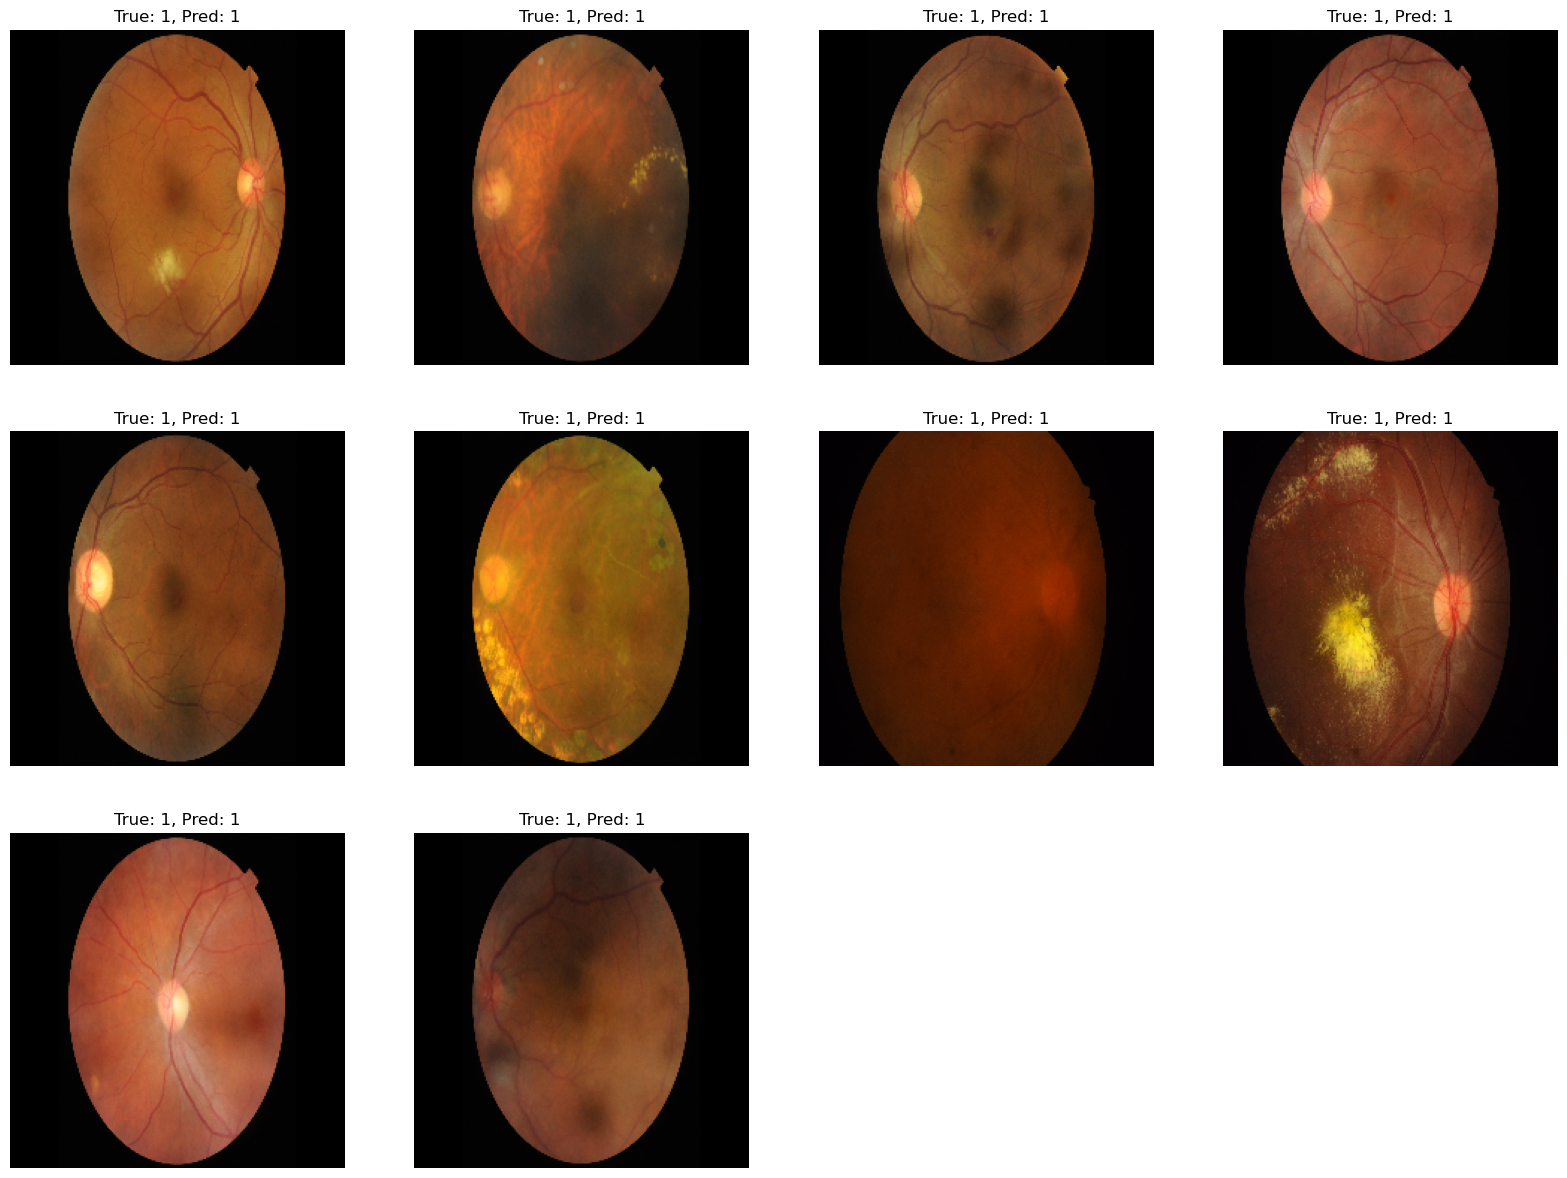

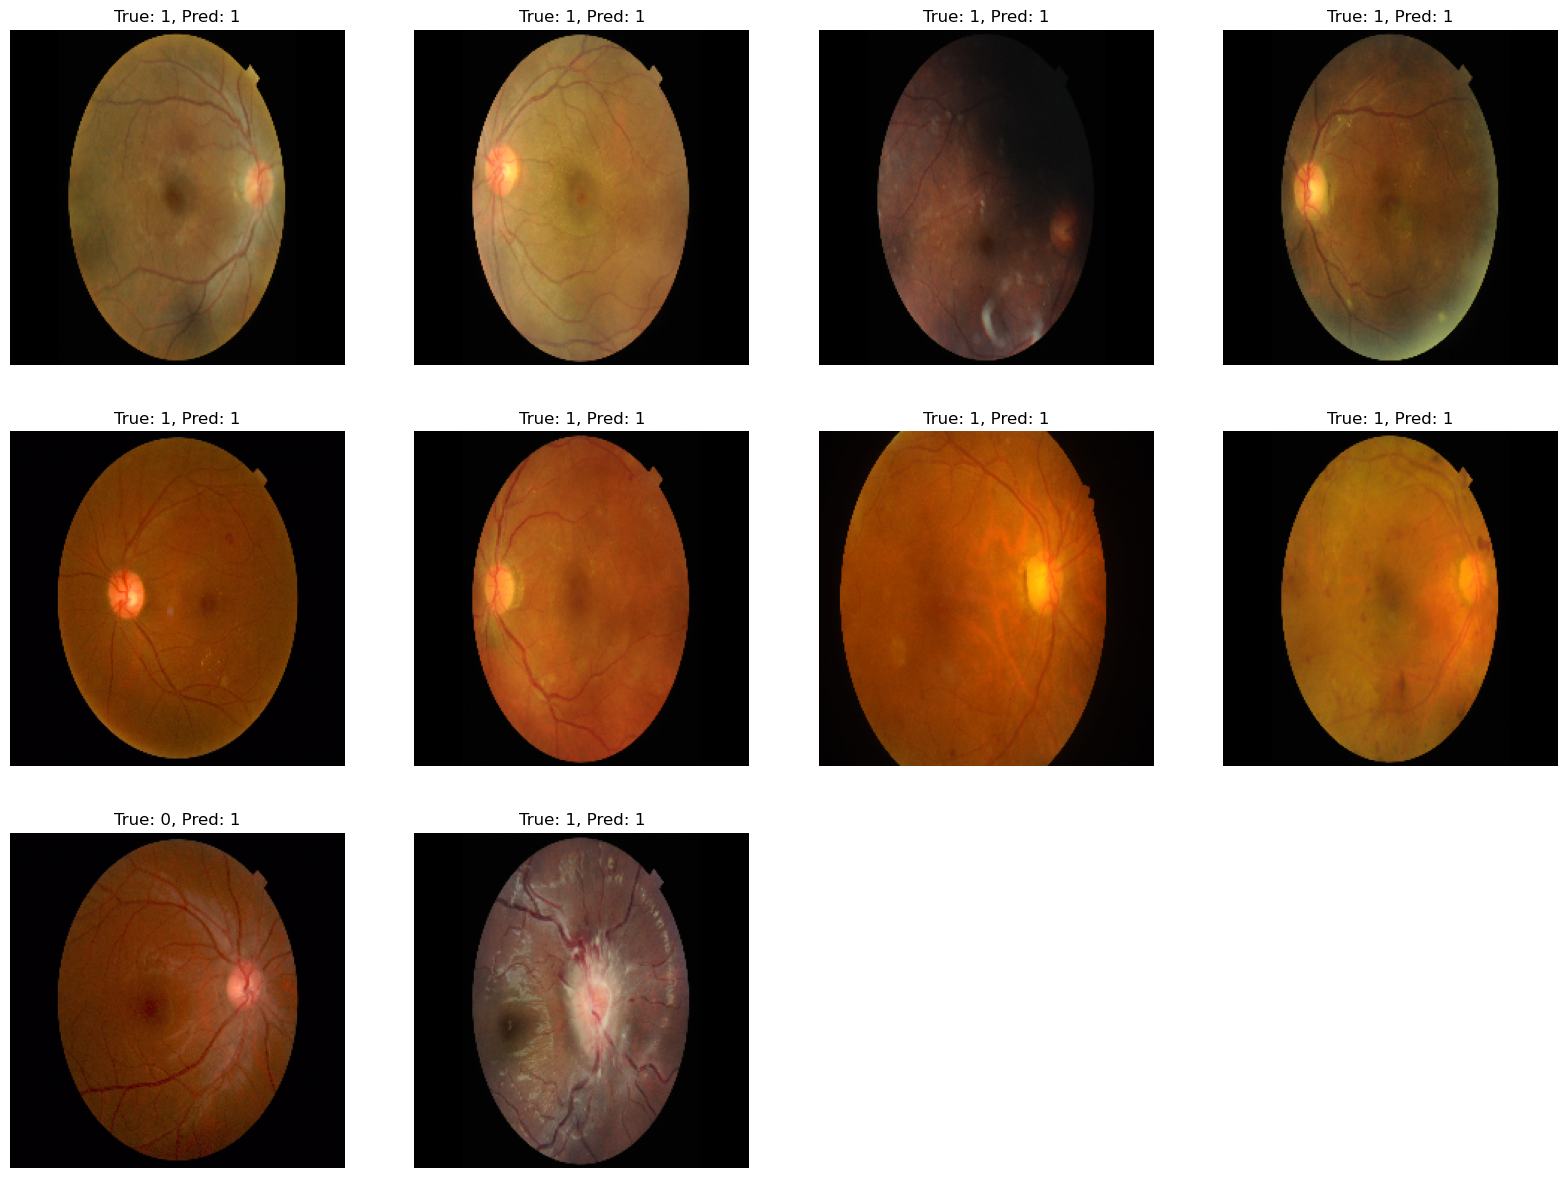

In [51]:
# Display random samples with actual and predicted labels
def display_random_samples(images, true_labels, pred_labels, sample_count=10):
    # Şekilleri kontrol et
    pred_labels = pred_labels.reshape(-1, 1) if len(pred_labels.shape) == 1 else pred_labels
    sample_count = min(sample_count, len(images))  # Maksimum görüntü sayısını aşma
    
    random_indices = np.random.choice(len(images), size=sample_count, replace=False)  # Rastgele indeks seç
    plt.figure(figsize=(20, 20))
    for i, idx in enumerate(random_indices):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[idx])
        plt.title(f"True: {true_labels[idx]}, Pred: {pred_labels[idx][0]}")
        plt.axis('off')
    plt.show()

display_random_samples(X_test, y_test, y_pred, sample_count=10)

# Rastgele örnekler görüntüleme
display_random_samples(X_test, y_test, y_pred, sample_count=10)
